In [5]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
import numpy as np

from typing import Generator, Iterable, List, Optional
import mediapy as media

In [6]:
model  = hub.load("https://tfhub.dev/google/film/1")

In [7]:

_UINT8_MAX_F = float(np.iinfo(np.uint8).max)

def load_image(img_url: str):
  if (img_url.startswith("https")):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image_data = response.content
  else:
    image_data = tf.io.read_file(img_url)

  image = tf.io.decode_image(image_data, channels=3)
  image_numpy = tf.cast(image, dtype=tf.float32).numpy()
  return image_numpy / _UINT8_MAX_F

In [8]:

image_1_url = "https://github.com/kanishkaryaa/frame_interpolation/blob/main/Photos/four.jpg?raw=true"
image_2_url = "https://github.com/kanishkaryaa/frame_interpolation/blob/main/Photos/six.jpg?raw=true"

time = np.array([0.5], dtype=np.float32)

image1 = load_image(image_1_url)
image2 = load_image(image_2_url)

In [9]:
input = {
    'time': np.expand_dims(time, axis=0),
     'x0': np.expand_dims(image1, axis=0),
     'x1': np.expand_dims(image2, axis=0)
}
mid_frame = model(input)


In [10]:
print(mid_frame.keys())

dict_keys(['backward_flow_pyramid', 'x1_warped', 'forward_residual_flow_pyramid', 'x0_warped', 'image', 'forward_flow_pyramid', 'backward_residual_flow_pyramid'])


input image one,generated image,input image two

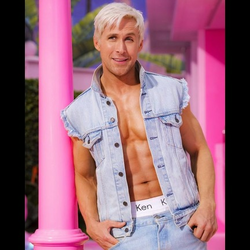
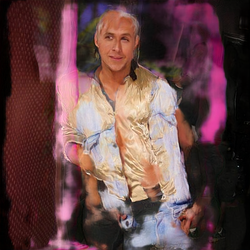
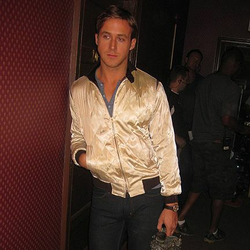

In [11]:
frames = [image1, mid_frame['image'][0].numpy(), image2]

media.show_images(frames, titles=['input image one', 'generated image', 'input image two'], height=250)

In [16]:
media.show_video(frames, fps=3, title='FILM interpolated video')

In [17]:
def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:

  if num_recursions == 0:
    yield frame1
  else:

    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:

  n = len(frames)
  for i in range(1, n):
    yield from _recursive_generator(frames[i - 1], frames[i],
                                    times_to_interpolate, interpolator)

  yield frames[-1]

In [18]:
media.show_video(frames, fps=3, title='FILM interpolated video')

In [19]:
def _pad_to_align(x, align):


  assert np.ndim(x) == 4
  assert align > 0, 'align must be a positive number.'

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height + height_to_pad,
      'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height,
      'target_width': width
  }
  return padded_x, bbox_to_crop


class Interpolator:


  def __init__(self, align: int = 64) -> None:

    self._model = hub.load("https://tfhub.dev/google/film/1")
    self._align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:

    if self._align is not None:
      x0, bbox_to_crop = _pad_to_align(x0, self._align)
      x1, _ = _pad_to_align(x1, self._align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self._model(inputs, training=False)
    image = result['image']

    if self._align is not None:
      image = tf.image.crop_to_bounding_box(image, **bbox_to_crop)
    return image.numpy()



In [20]:
def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:

  if num_recursions == 0:
    yield frame1
  else:

    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:

  n = len(frames)
  for i in range(1, n):
    yield from _recursive_generator(frames[i - 1], frames[i],
                                    times_to_interpolate, interpolator)

  yield frames[-1]

In [21]:
times_to_interpolate = 6
interpolator = Interpolator()

input_frames = [image1, image2]
frames = list(
    interpolate_recursively(input_frames, times_to_interpolate,
                                        interpolator))

In [22]:

print(f'video with {len(frames)} frames')
media.show_video(frames, fps=30, title='FILM interpolated video')

video with 65 frames
